In [160]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [205]:
from analysis.data.dataframe_creation import pipeline
sd = "2018-01-01"
ed = "2024-01-01"
dataset = pipeline(sd, ed)

[                       0%                       ]

Total number of tickers 502


[*********************100%***********************]  502 of 502 completed

5 Failed downloads:
['GEV']: ChunkedEncodingError(ProtocolError('Connection broken: IncompleteRead(5360 bytes read, 784 more expected)', IncompleteRead(5360 bytes read, 784 more expected)))
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['SW', 'SOLV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1704085200")')


Null values: False
NaN values: False

Creating features
The dataset has 485 assets
The dataset has 14 predictors:
Ticker
Yavg_return
Yavg_volatility
Davg_span
Davg_volume
D_eSkewness
D_eVaR
D_eCVaR
D_eCurtosis
Sharpe_ratio
totalEsg
environmentScore
socialScore
governanceScore
industry


Dataset creation finished



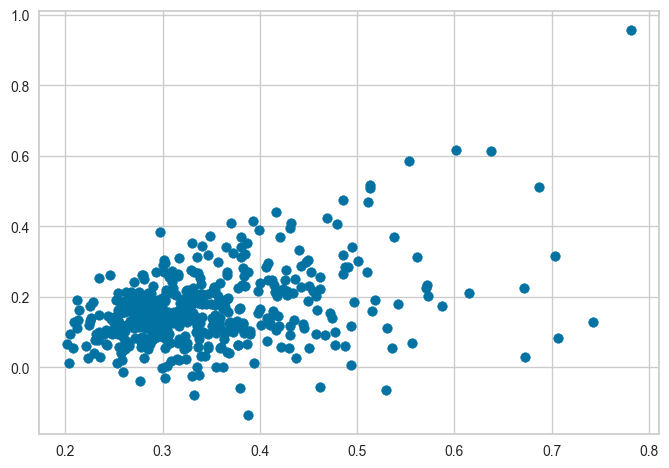

In [162]:
plt.scatter(dataset["Yavg_volatility"], dataset["Yavg_return"])
plt.show()

In [206]:
outliers = outliers = dataset[
    (dataset["Yavg_return"] > 0.8)]["Ticker"].unique()
final_dataframe = dataset[~dataset["Ticker"].isin(outliers)]
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,industry
0,A,0.170255,0.290318,2.268208,1.961764e+06,-0.134996,-0.000283,-0.000401,4.334472,0.517552,11.36,1.19,6.23,3.93,Life Sciences Tools and Services
1,AAPL,0.309906,0.316770,2.378506,1.073273e+08,-0.036492,-0.000292,-0.000426,4.924360,0.915194,16.79,0.55,7.52,8.72,Technology
2,ABBV,0.159055,0.273195,2.003774,7.196053e+06,-0.845041,-0.000286,-0.000483,13.941112,0.508994,26.10,1.78,15.70,8.62,Biotechnology
3,ABT,0.155088,0.257788,1.733056,5.701730e+06,0.048215,-0.000290,-0.000434,6.096837,0.524026,22.21,1.81,13.84,6.56,Health Care
4,ACGL,0.204344,0.314158,0.905297,1.859299e+06,-0.321692,-0.000771,-0.001249,11.651915,0.586789,20.27,1.57,9.92,8.78,Insurance


In [207]:
stock_data_clustering = final_dataframe[["Yavg_return",	"Yavg_volatility"]]

stock_data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 484 entries, 0 to 484
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Yavg_return      484 non-null    float64
 1   Yavg_volatility  484 non-null    float64
dtypes: float64(2)
memory usage: 11.3 KB


In [208]:
from sklearn.preprocessing import MinMaxScaler
for attr in stock_data_clustering.columns:
    scaler = MinMaxScaler()
    stock_data_clustering[attr] = scaler.fit_transform(stock_data_clustering[attr].values.reshape(-1, 1)).flatten()

In [209]:

from analysis.clustering.kmeans_clustering import run_kmeans
clusters = range(2, 20)
runs = 60
meanDistortions, sil_score, inertias = run_kmeans(clusters, stock_data_clustering, runs)
        # print("\nNumber of Clusters:", k, "\tAverage Distortion:", distortion)
        # print("For n_clusters = {}, silhouette score is {}".format(k, score))

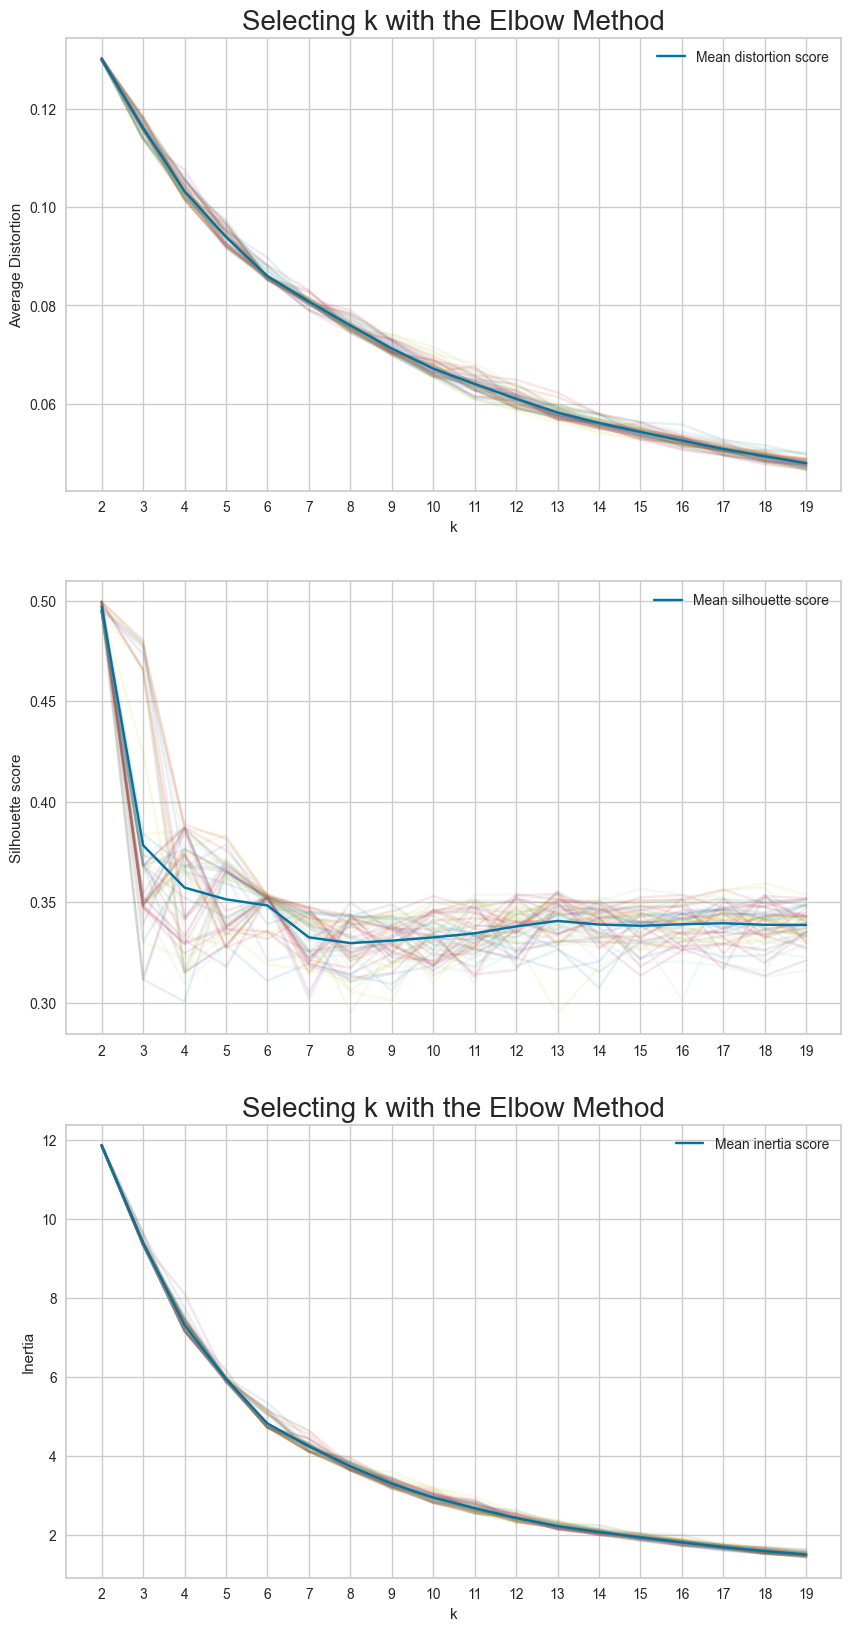

In [210]:
from analysis.data.plotting import plot_kmeans
plot_kmeans(runs, clusters, meanDistortions, sil_score, inertias)

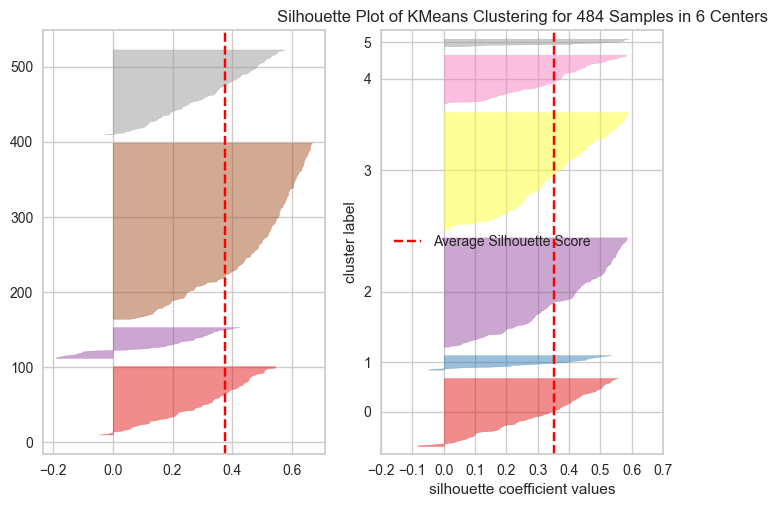

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 484 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [211]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
plt.subplot(1,2,1)
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(stock_data_clustering)
plt.subplot(1,2,2)
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))

visualizer.fit(stock_data_clustering)

visualizer.show()

In [212]:
N_SECTORS = 6

kmeans = KMeans(n_clusters=N_SECTORS, random_state=0)
kmeans.fit(stock_data_clustering)
final_dataframe["Sector"] = kmeans.labels_
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,industry,Sector
0,A,0.170255,0.290318,2.268208,1.961764e+06,-0.134996,-0.000283,-0.000401,4.334472,0.517552,11.36,1.19,6.23,3.93,Life Sciences Tools and Services,0
1,AAPL,0.309906,0.316770,2.378506,1.073273e+08,-0.036492,-0.000292,-0.000426,4.924360,0.915194,16.79,0.55,7.52,8.72,Technology,4
2,ABBV,0.159055,0.273195,2.003774,7.196053e+06,-0.845041,-0.000286,-0.000483,13.941112,0.508994,26.10,1.78,15.70,8.62,Biotechnology,0
3,ABT,0.155088,0.257788,1.733056,5.701730e+06,0.048215,-0.000290,-0.000434,6.096837,0.524026,22.21,1.81,13.84,6.56,Health Care,0
4,ACGL,0.204344,0.314158,0.905297,1.859299e+06,-0.321692,-0.000771,-0.001249,11.651915,0.586789,20.27,1.57,9.92,8.78,Insurance,4


In [213]:
cluster_profile = final_dataframe.groupby("Sector").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = final_dataframe.groupby("Sector")["Ticker"].count().values
cluster_profile["Sharpe_ratio"] = (cluster_profile["Yavg_return"]-0.02)/cluster_profile["Yavg_volatility"]
cluster_profile.style.highlight_max(color="green", axis=0)

,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,Count
Sector,,,,,,,,,,,,,,
0,0.125860,0.271997,2.610616,3566153.756368,-0.164795,-0.000384,-0.000612,11.763846,0.389194,20.499436,6.152974,9.064718,5.281538,195
1,0.397875,0.488224,4.961252,27252647.165894,0.069113,-0.001080,-0.001680,11.382690,0.773979,19.771667,6.113103,8.417931,5.216552,30
2,0.141946,0.448964,2.549813,6973865.986243,-0.086304,-0.001040,-0.001657,13.846527,0.271616,21.530000,6.455000,8.946481,6.127963,54
3,0.078211,0.347453,2.008640,5290505.530966,-0.107989,-0.000790,-0.001254,12.896693,0.167537,20.789412,5.383412,9.367412,6.038588,88
4,0.239756,0.340443,5.702918,5250826.356193,0.011244,-0.000403,-0.000630,10.155836,0.645501,18.759231,4.319038,8.858077,5.582500,105
5,0.172979,0.625919,2.518135,10231385.574332,0.045046,-0.001752,-0.003117,21.088915,0.244408,28.146667,12.430833,10.224167,5.491667,12


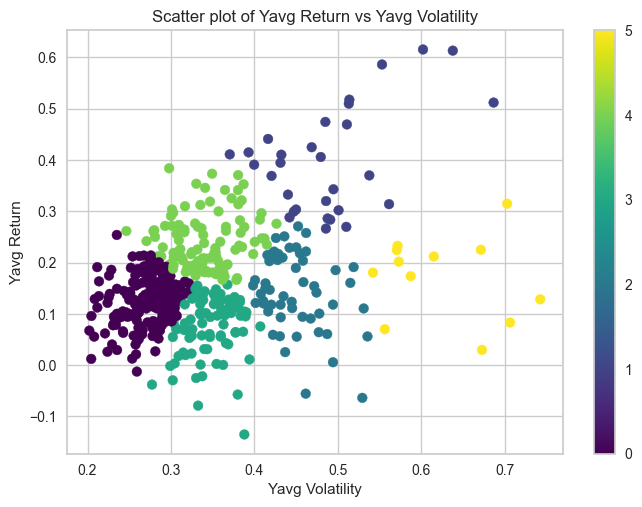

In [214]:
plt.scatter(
    final_dataframe["Yavg_volatility"], 
    final_dataframe["Yavg_return"], 
    c=final_dataframe["Sector"],  # Use c for color mapping
    cmap='viridis',  # Optional: Choose a colormap
    
)

# Add labels and title
plt.xlabel("Yavg Volatility")
plt.ylabel("Yavg Return")
plt.title("Scatter plot of Yavg Return vs Yavg Volatility")
plt.colorbar()
# Show the plot
plt.show()

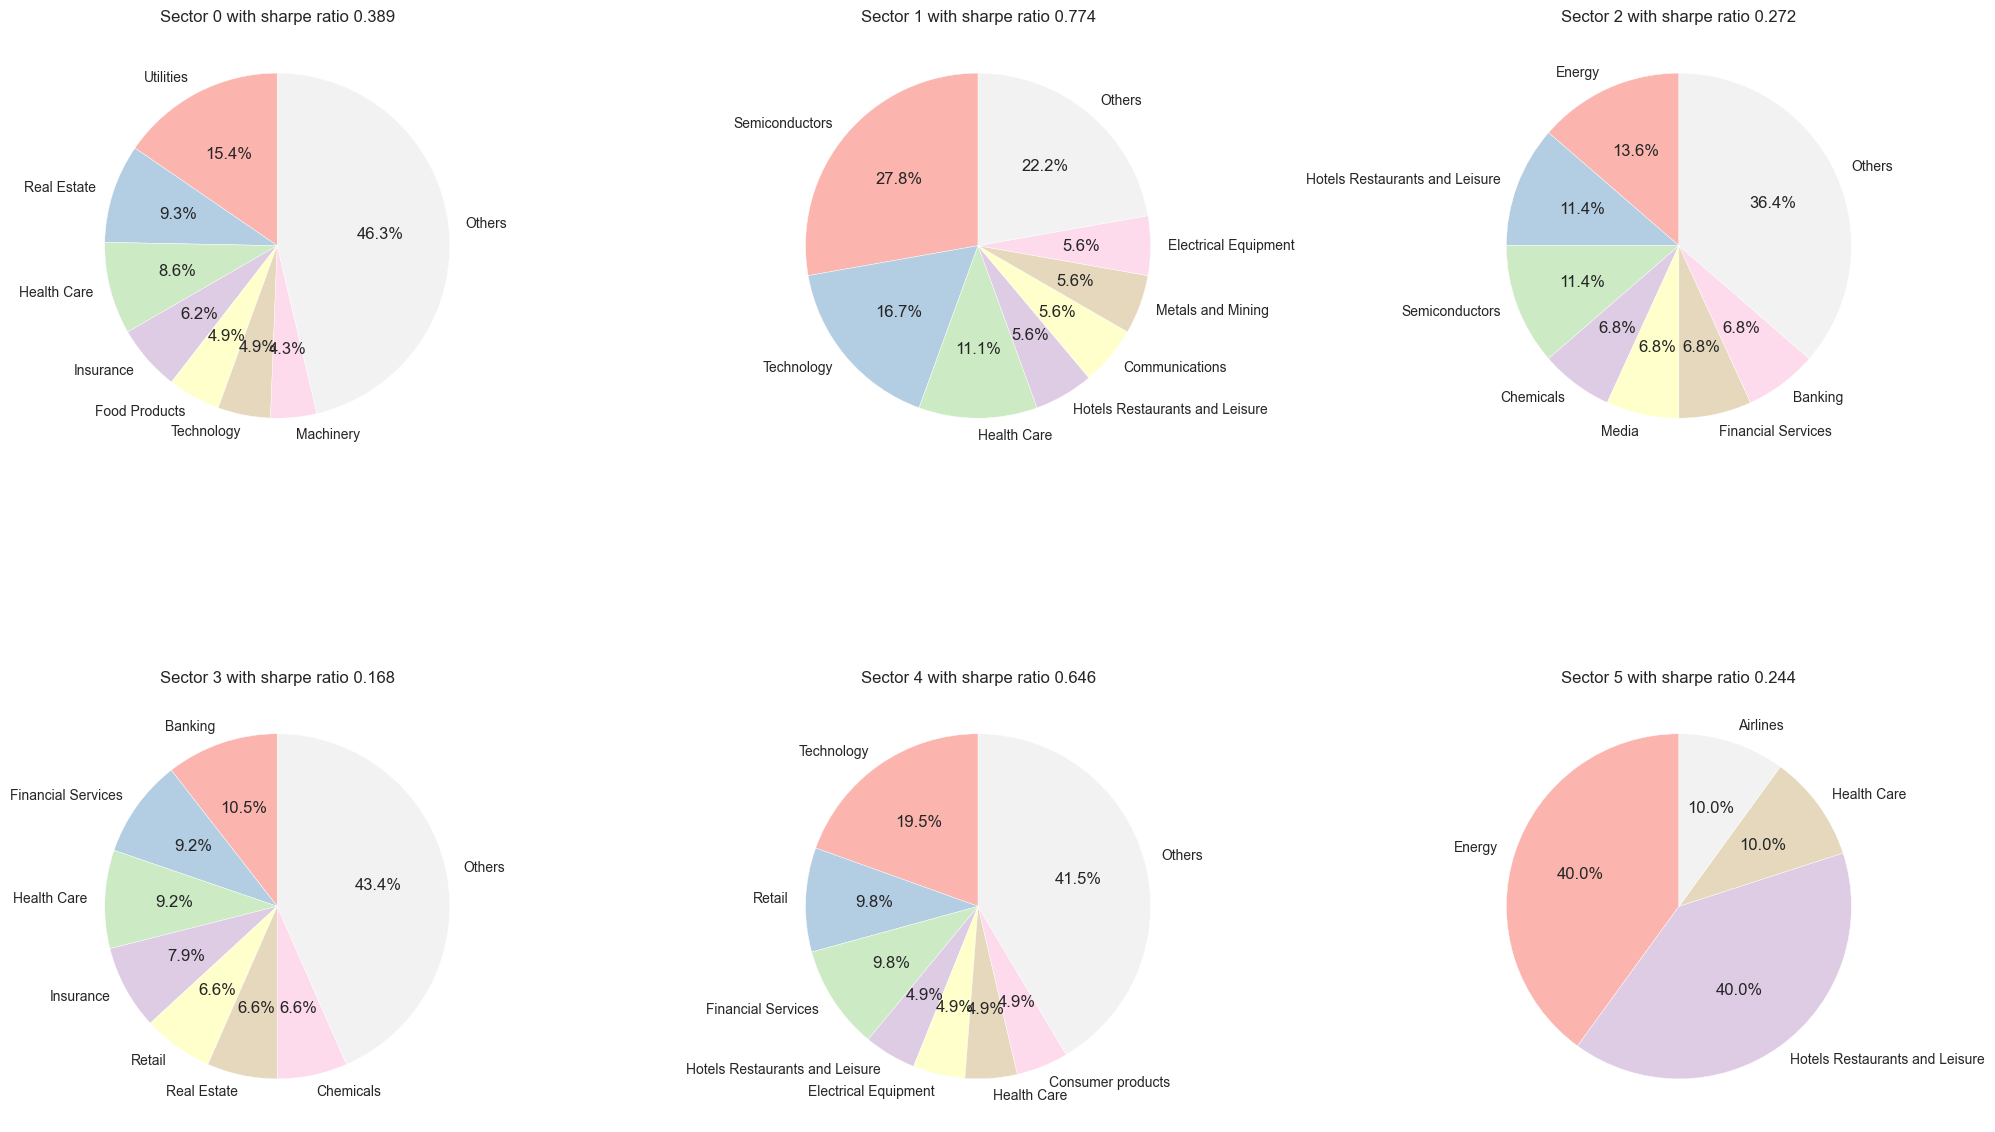

In [215]:
MAX_LABELS = 7
from analysis.data.plotting import plot_cluster_industry
plot_cluster_industry(MAX_LABELS, final_dataframe, cluster_profile)


In [249]:
import analysis.data.dataframe_creation as dataframe_creation
importlib.reload(dataframe_creation)
from analysis.data.dataframe_creation import create_portfolio_clustered
portfolio_ret, asset_ret = create_portfolio_clustered(sd, ed, final_dataframe, list(final_dataframe["Ticker"]), w = "sharpe")


[*********************100%***********************]  484 of 484 completed


Null values: False
Null values: False


In [235]:
benchmark = yf.download(tickers="SPY", start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


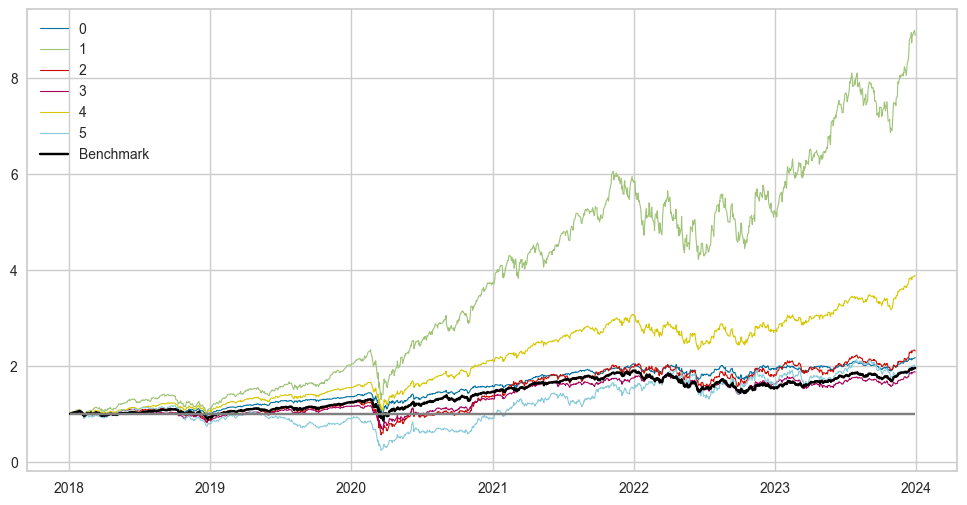

In [251]:
import analysis.data.plotting as plotting
importlib.reload(plotting)
from analysis.data.plotting import portfolio_evolution_time
portfolio_evolution_time(portfolio_ret, benchmark)

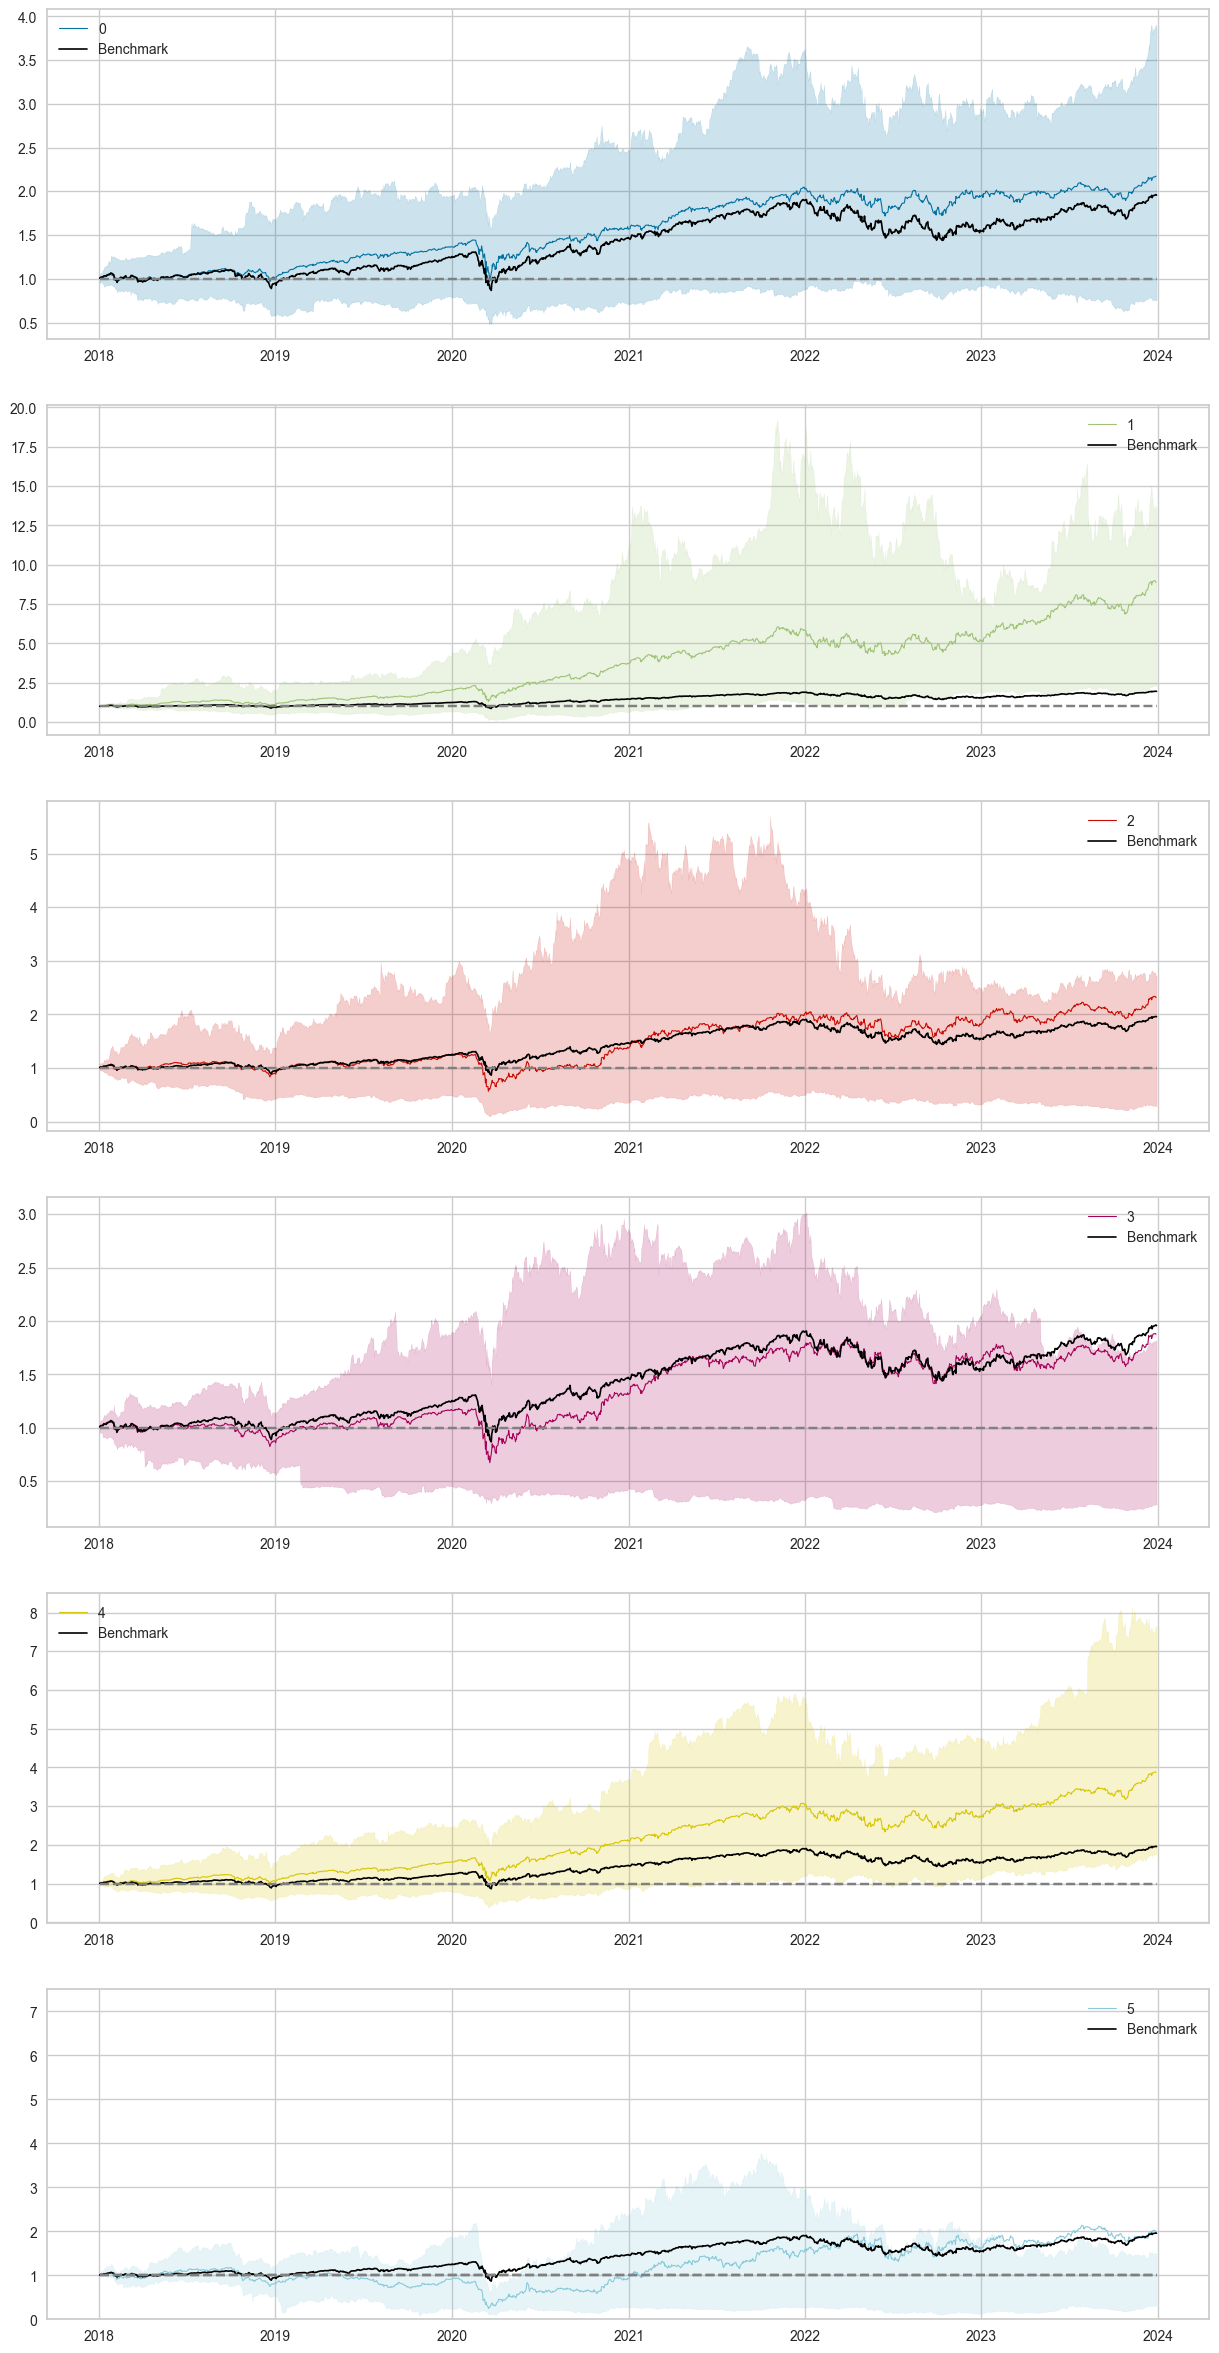

In [252]:
from analysis.data.plotting import portfolio_span
portfolio_span(asset_ret, portfolio_ret, final_dataframe, benchmark, N_SECTORS)


In [254]:
sd_test = ed
ed_test = "2025-01-10"
portfolio_ret_t, asset_ret_t = create_portfolio_clustered(sd_test, ed_test, final_dataframe, list(final_dataframe["Ticker"]), w="sharpe")

[*********************100%***********************]  484 of 484 completed

128 Failed downloads:
['ES', 'PM', 'WTW', 'CLX', 'ZBH', 'TJX', 'AVY', 'NXPI', 'LYB', 'O', 'APO', 'HD', 'BA', 'FRT', 'MPC', 'PODD', 'STX', 'IRM', 'MKC', 'MS', 'BKR', 'AFL', 'RSG', 'BDX', 'MOH', 'ETR', 'D', 'HUM', 'MPWR', 'ELV', 'MTB', 'GEN', 'PYPL', 'ANET', 'GM', 'FOXA', 'WEC', 'CMG', 'GPN', 'POOL', 'EFX', 'LIN', 'PPL', 'UNP', 'DAL', 'SBAC', 'CBRE', 'HRL', 'JCI', 'CPB', 'CDW', 'ADBE', 'CF', 'CTAS', 'DAY', 'AOS', 'CPRT', 'CRM', 'COO', 'MU', 'ODFL', 'IR', 'AON', 'MTD', 'SHW', 'LHX', 'ITW', 'VST', 'VLO', 'MKTX', 'PCG', 'PAYX', 'MET', 'KEY', 'FAST', 'LKQ', 'MDT', 'PNR', 'PGR', 'HSIC', 'CVS', 'BIIB', 'GOOG', 'SLB', 'ORLY', 'LLY', 'ADM', 'LDOS', 'ESS', 'J', 'OMC', 'CI', 'HAL', 'DHR', 'VRSN', 'FTV', 'DE', 'ECL', 'NOC', 'SMCI', 'PLD', 'AVB', 'SJM', 'WAT', 'MCK', 'TXT', 'DVA', 'UAL', 'EPAM', 'DVN', 'WBD', 'FOX', 'FTNT', 'PG', 'BRO', 'ARE', 'ZBRA', 'HBAN', 'A', 'AXON', 'PNW', 'STE', 'AIG', 'ABBV', 'CCI', 'PPG', 'EBAY']: YFR

Null values: False
Null values: False


In [127]:
benchmark_t = yf.download(tickers="SPY", start=sd_test, end=ed_test, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


In [139]:
def weights(ratios, cluster, pow, thresh):
    w = np.array(ratios["Sharpe_ratio"] > thresh)*ratios["Sharpe_ratio"]
    ratios["weights"] = np.power(w, pow)
    ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
    return ratios.loc[ratios["Sector"] == cluster, "weights"]

In [145]:
import quantstats as qs

returns = np.zeros(len(portfolio_ret_t))
cp = cluster_profile.reset_index()
for i in portfolio_ret_t.columns:
        weight = weights(cp[["Sector", "Sharpe_ratio"]], i, 1, 0.25).values[0]
        returns += weight*portfolio_ret_t[i] 
portfolio_performance = pd.DataFrame(returns).reset_index()

0.07263691513616886
0.571275966440547
0.024690083580836405
0.0
0.3313970348424477
0.0


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-01-04   2024-01-04
End Period                 2025-01-08   2025-01-08
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          27.36%       30.53%
CAGR﹪                     17.91%       19.9%

Sharpe                     1.96         1.61
Prob. Sharpe Ratio         97.18%       94.38%
Smart Sharpe               1.95         1.6
Sortino                    2.86         2.38
Smart Sortino              2.84         2.37
Sortino/√2                 2.02         1.68
Smart Sortino/√2           2.01         1.67
Omega                      1.3          1.3

Max Drawdown               -8.41%       -10.5%
Longest DD Days            64           64
Volatility (ann.)          12.57%       17.34%
R^2                        0.83         0.83
Information Ratio          0.03         0.03
Calmar                  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-07-17,2024-08-05,2024-09-18,64,-10.498317,-10.309512
2,2024-04-01,2024-04-19,2024-05-14,44,-7.486085,-6.815091
3,2024-12-05,2024-12-19,2025-01-08,35,-7.175200,-7.072060
4,2024-10-15,2024-10-31,2024-11-05,22,-4.085952,-3.676955
5,2024-11-12,2024-11-15,2024-11-21,10,-4.058594,-3.092465


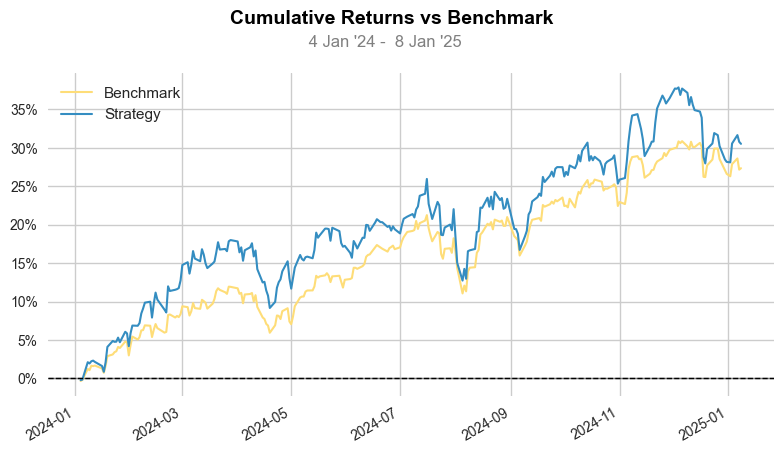

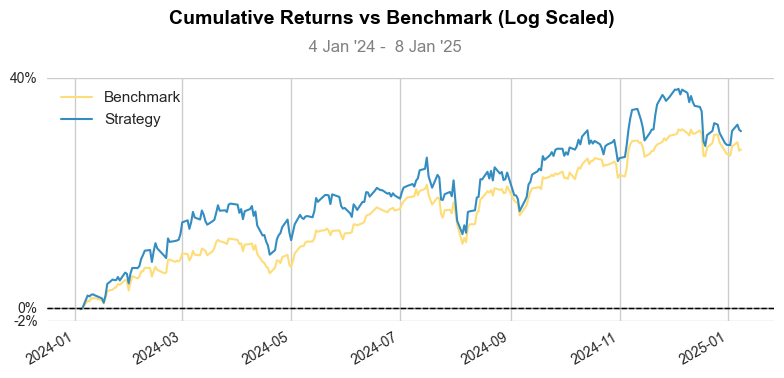

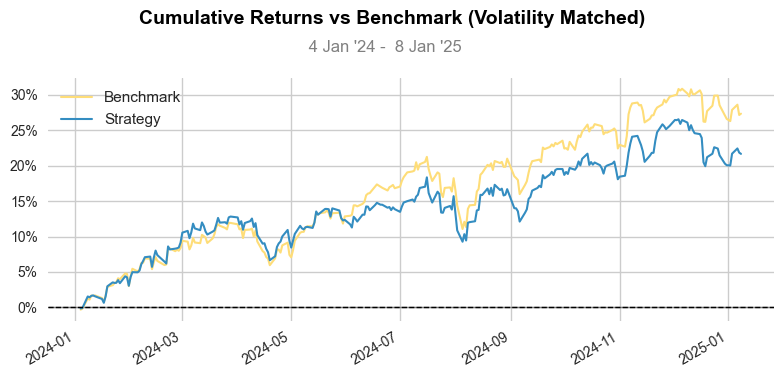

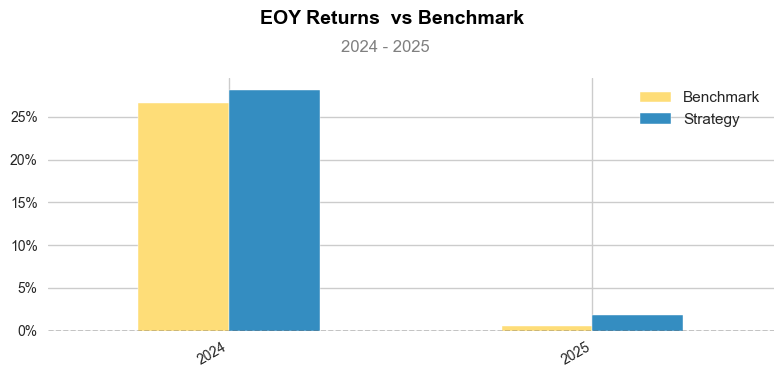

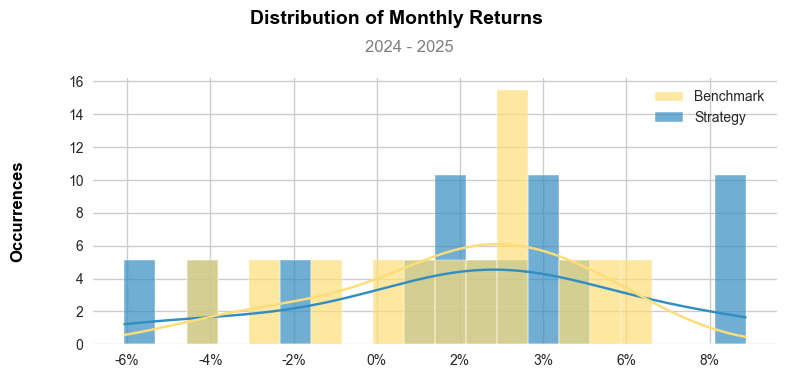

UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [146]:
portfolio_performance["Date"] = pd.to_datetime(portfolio_performance["Date"])

# Set "Date" as the index
portfolio_performance.set_index("Date", inplace=True)

# Rename the column for better clarity (optional)
portfolio_performance.columns = ["Returns"]

# Ensure the returns are properly formatted and call the quantstats report
qs.reports.full(portfolio_performance["Returns"], benchmark="SPY")